In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as si

In [ ]:
def force_nuclear_envelope(L_micron, R_micron, σ=0.013, κ=40):
    """
    Computes force due to a nuclear envelope deformation with length L and radius R
    Uses the equations of Derenyi et al Phys Rev Let 2002, eqn 13

    Arguments:
    - L_micron: length of the membrane tube, in micron.
    - R_micron: radius of the membrane tube, in micron.
    - σ: nuclear envelope tension, in pN/nm. Default value 0.013 for pombe NE
    - κ: nuclear envelope bending modulus, in pN nm. Default value 40 for pombe NE

    Returns:
    - f: force exerted by the envelope, in pN

    """
    #constants of integration
    a1 = 0.746
    a2 = 0.726
    α1 = 0.347
    α2 = 3.691

    #convert lengths to nm for force calculation
    L = L_micron * 1000
    R = R_micron * 1000

    f_0 = 2 * np.pi * R * (κ/(2 * R**2) + σ)

    if L <= 0:
        f = 0

    else:
        f = f_0 * (1 + 2 * a1 * a2 * np.exp(-L / (np.sqrt(2) * R)) * np.cos(L / (np.sqrt(2) * R) + α1 + α2))

    return f

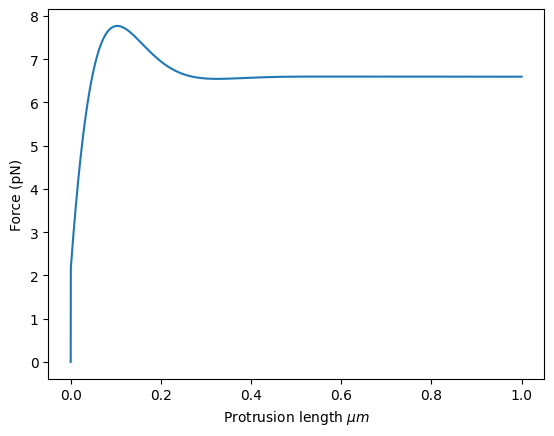

In [ ]:
# plot force function
σ = 0.013       # pN/nm, surface tension
κ = 40        # pN nm, bending modulus
R = 0.05       # micron, protrusion radius
L_array = np.linspace(0, 1, 10000)
f_array = np.zeros_like(L_array)

for j in range(len(L_array)):
    f_array[j] = force_nuclear_envelope(L_array[j], R, σ, κ)
np.save('Length', L_array)
np.save('NE_force', f_array)
plt.xlabel('Protrusion length $\mu m$')
plt.ylabel('Force (pN)')
plt.plot(L_array, f_array)

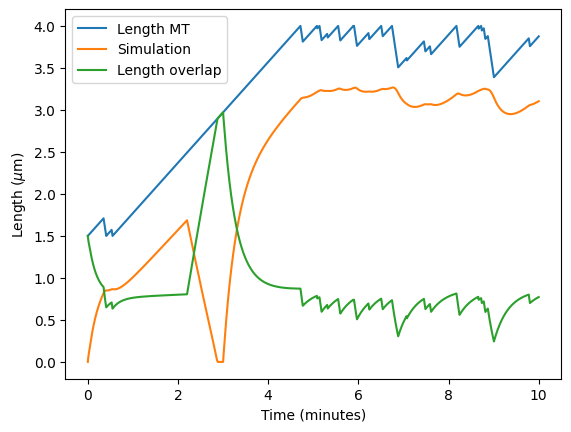

In [ ]:
# @title Default title text
# Euler step for model with constant Cut7 sliding force per unit length, MT drag, and MT dynamic instability
import random
def protrusion_model(dt, u, params,t):
    """
    Does one Euler step of protrusion model
    2nd version:
       - MT dynamic instability (growth/shrinkage)
       - Constant Cut7 sliding force per unit length
       - MT drag based on a long rod

    Arguments:
    - dt: timestep, in sec
    - u: array of current components of solution
        u[0] = L_mt, in nm
        u[1] = L_protrusion, in nm
        u[2] = L_overlap, in nm
        u[3] = MT state, 0 is growing, 1 is shrinking
    - params: array of parameters
        params[0] = σ, nuclear envelope tension in pN/nm
        params[1] = κ, nuclear envelope bending modulus, in pN nm
        params[2] = R, protrusion radius, in nm
        params[3] = f_cut7, force per unit length, in pN/nm of overlap
        params[4] = η_mt, viscosity for MT drag, in pN/nm
        params[5] = v_g, MT growth speed, in micron/min
        params[6] = v_s, MT shrinking speed, in micron/min
        params[7] = f_c, catastrophe frequency, in /min
        params[8] = f_r, rescue frequency, in /min
        params[9] = L_min, minimum MT length, in micron
        params[10] = L_max, maximum MT length, in micron
        params[11] = break_time, time to stop cut7 force for break and shrinkage simualtions in min
        params[12] = resume_time, time to resume cut7 force for break and shrinkage simualtions in min
        Note: Set break_time and resume_time to 0 if not doing break and shrinkage simulations

    Returns:
    - du: array of derivatives and states
        du[0] = d/dt L_mt, in nm/s
        du[1] = d/dt L_protrusion, in nm/s
        du[2] = d/dt L_overlap, in nm/s
        du[3] = new MT state (0 or 1)

    """



    du = np.zeros_like(u)              #initialization

    L_mt, L_protrusion, L_overlap, state = u             #variables from u
    σ, κ, R, f_cut7, η_mt, v_g, v_s, f_c, f_r, L_min, L_max, break_time,resume_time = params                #parameters
    # MT drag coefficient
    γ_mt = 2 * np.pi * η_mt * L_mt / ( np.log(L_mt / ( 2 * R)) - 0.114 )

    # force balance equation for MT velocity: γv = f_cut7 L - F_NE

    #During of Cut7 force for growth and shrinkage
    if t>break_time and t<resume_time:
      f_cut7=0

    v = (f_cut7 * L_overlap - force_nuclear_envelope(L_protrusion, R, σ, κ)) / (γ_mt)
    a1 = 0.746
    a2 = 0.726
    α1 = 0.347
    α2 = 3.691
    R  = 0.05
    #Get total force from nuclear envelope and cut7 at overlap
    force=f_cut7 * L_overlap - force_nuclear_envelope(L_protrusion, R, σ, κ)

    # determine MT length change based on current state
    if state == 0:   #MT is growing
        dL = v_g
    elif state == 1:
        dL = -v_s #MT is shrinking
    else:
        dL = 0

    #check for state changes
    du[3] = state    #default: stay in the state you are in
    if state == 0:   #MT is growing
        p_switch = f_c * dt
        if np.random.rand(1) < p_switch:  #switch to shrinking
            du[3] = 1
    elif state == 1:  #MT is shrinking
        p_switch = f_r * dt
        throw = np.random.rand(1)
        if throw < p_switch:  #switch to growing
            du[3] = 0

    if L_mt + dL*dt <= L_min:  #MT will shorten too much on this step
        du[0] = (L_min-L_mt)/dt
        du[1] = v
        du[2] = -v + (L_min-L_mt)/dt
        du[3] = 0    #automatic rescue
    elif L_mt + dL*dt >= L_max:  #MT will lengthen too much on this step
        du[0] = (L_max-L_mt)/dt
        du[1] = v
        du[2] = -v + (L_max-L_mt)/dt
        du[3] = 1    #automatic catastrophe
    else:
        du[0] = dL          #change in MT length
        du[1] = v           #L_protrusion
        du[2] = -v + dL     #L_overlap

    return du, force

σ = 0.013  # pN/nm, surface tension
κ = 40.         # pN nm, bending modulus
R = 0.05     # micron, protrusion radius
f_cut7 = 10.  # pN/micron, sliding force per length
η_mt = .5     # pN s/micron^2, 1000x 60x water viscosity
v_g = .6    #micron/min
v_s = 3.6      #micron/min
f_c = 1.15        #/min
f_r = 20      #/min
L_min = 1.5    #micron, min MT length
L_max = 4     #micron, max MT length
break_time=2.2  #min, time when cut7 force stops
resume_time=3 #min, time when cut7 force resumes
t=0
params = (σ, κ, R, f_cut7, η_mt, v_g, v_s, f_c, f_r, L_min, L_max, break_time, resume_time)

L_mt0 = L_min    #micron, initial condition
γ_mt = 2 * np.pi * η_mt * L_mt0 / ( np.log(L_mt0 / ( 2 * R)) - 0.114 )

L_p0 = 0        #micron, protrusion initial condition
L_o0 = L_min       #micron, overlap initial condition

t_max = 10      #min

t_array = np.linspace(0, t_max, 10000)
dt = t_array[1] - t_array[0]
u = np.array([np.zeros_like(t_array), np.zeros_like(t_array),np.zeros_like(t_array),np.zeros_like(t_array)])
u[0, 0] = L_mt0
u[1, 0] = L_p0
u[2, 0] = L_o0
u[3, 0] = 0    #begin growing
force_array=[]
force_array.append(0)
du = np.array([0, 0, 0])
#Iterate over timesteps
for j in range(len(t_array)-1):
    du, force = protrusion_model(dt, u[:,j], params,t)
    force_array.append(force)
    u[0:3, j+1] = u[0:3,j] + dt * du[0:3]
    u[3, j+1] = du[3]
    t+=dt

#Graph result
L_mt = u[0,:]
L_protrusion = u[1,:]
L_overlap = u[2,:]
state = u[3,:]
plt.plot(t_array, L_mt, label='Length MT')
plt.plot(t_array, L_protrusion, label='Simulation')
plt.plot(t_array, L_overlap, label='Length overlap')
np.save('Time', t_array)
np.save('Growth_and_Shrinkage', L_protrusion)

plt.xlabel('Time (minutes)')
plt.ylabel('Length ($\mu$m)')
plt.legend()
